<class 'numpy.ndarray'>
<class 'matplotlib.axes._subplots.AxesSubplot'>


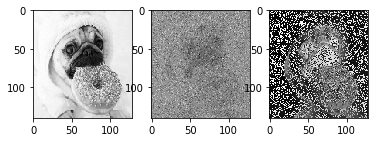

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
from scipy.misc import imread
import pandas as pd 


def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im).astype('float')
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2
    # proportion of pixels to alter
    
prop = 0.7
varSigma = 0.5
im = imageio.imread('grey_pug.jpg')
im = im/255
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
print(type(im2))
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
print(type(ax2))
im3 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')

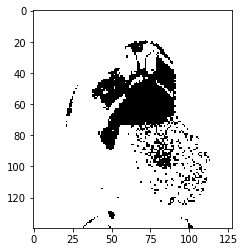

In [34]:
img_gray_arr = np.asarray(im)
x = np.rint(img_gray_arr)
img_mean = np.mean(x)
img_arr = np.copy(x)
img_arr[x<img_mean] = -1
img_arr[x>=img_mean] = 1


plt.imshow(img_arr, cmap = 'gray')

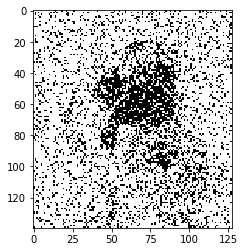

In [35]:
noisy_img_gray_arr = np.asarray(im2)
y = np.rint(noisy_img_gray_arr)
noisy_img_mean = np.mean(y)
noisy_img_arr = np.copy(y)
noisy_img_arr[y<noisy_img_mean] = -1
noisy_img_arr[y>=noisy_img_mean] = 1

plt.imshow(noisy_img_arr, cmap = 'gray')

In [36]:
def percent_pixel_flipped(noisy_arr,denoised_arr):
    num_flipped = 0
    total_px = noisy_arr.shape[0]*noisy_arr.shape[1]
    for i in range(noisy_arr.shape[0]):
        for j in range(noisy_arr.shape[1]):
            if noisy_arr[i,j]!= denoised_arr[i,j]:
                num_flipped+=1
   
    percent_change = num_flipped*100./total_px
    return percent_change

print (percent_pixel_flipped(noisy_img_arr, img_arr))

19.453125


In [37]:
constant = [0,1,.02]
hidden_image = np.copy(noisy_img_arr)
print(hidden_image[0][2])



print(hidden_image)


1.0
[[ 1.  1.  1. ...  1.  1.  1.]
 [ 1. -1.  1. ...  1. -1. -1.]
 [ 1. -1.  1. ...  1.  1.  1.]
 ...
 [ 1.  1.  1. ...  1.  1.  1.]
 [ 1.  1.  1. ...  1.  1.  1.]
 [-1.  1.  1. ...  1. -1.  1.]]


In [38]:

def ProbY(y_array,x_array,X1, X2,i, j, constant):
    n = constant[2]
    energy = 0
    energy = -n * x_array[X1][X2] * y_array[i][j]
    prob = np.exp(-energy)
    #print("probY", prob)
    return prob



In [39]:
PX =[]
PXM = []
normX = []
normXM1 = []

def check_limit(value, limit):
    if value<0:
        value=limit-1
    if value==limit:
        value=0
    return value

def ProbX1(y_array,x_array,i, j, constant):
    energy = 0
    b = constant[1]
    x_neighbour = [-1,1]
    y_neighbour = [-1,1]
    energy = 0
    for k in x_neighbour:
        for l in y_neighbour:
            x_n = check_limit(i +k, x_array.shape[0])
            y_n = check_limit(j +l, x_array.shape[1])
            x_array[i][j] = 1
            energy += -b*x_array[i][j]*x_array[x_n][y_n]
    prob = np.exp(-energy)
    PX.append(prob)
    #print ("ProbX", prob)
    return prob

def ProbXM1(y_array,x_array,i, j, constant):
    energy = 0
    b = constant[1]
    x_neighbour = [-1,1]
    y_neighbour = [-1,1]
    energy = 0
    for k in x_neighbour:
        for l in y_neighbour:
            x_n = check_limit(i +k, x_array.shape[0])
            y_n = check_limit(j +l, x_array.shape[1])
            x_array[i][j] = -1
            energy += -b*x_array[i][j]*x_array[x_n][y_n]
    prob = np.exp(-energy)
    PXM.append(prob)
    #print ("ProbX", prob)
    return prob

    


In [40]:
def mainprob1(ProbX1, ProbXM1, ProbY, i, j):
    P1 = ProbX1(noisy_img_arr , hidden_image, i, j, constant)*ProbY(noisy_img_arr, hidden_image, 1, 1, i, j, constant)
    P2 = ProbXM1(noisy_img_arr , hidden_image, i, j, constant)*ProbY(noisy_img_arr, hidden_image, -1, -1, i, j, constant)
    #print("P1", P1)
    #print("P2", P2)
    P = P1/(P1+P2)
    return P

def mainprobM1(ProbX1, ProbXM1, ProbY, i, j):
    P1 = ProbX1(noisy_img_arr , hidden_image, i, j, constant)*ProbY(noisy_img_arr, hidden_image, 1, 1, i, j, constant)
    P2 = ProbXM1(noisy_img_arr , hidden_image, i, j, constant)*ProbY(noisy_img_arr, hidden_image, -1, -1, i, j, constant)
    #print("P1", P1)
    #print("P2", P2)
    P = P2/(P1+P2)
    return P


In [41]:
new_hidden_arr = np.copy(hidden_image)
print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))

for T in range(2):
    for i in range(hidden_image.shape[0]):
        for j in range(hidden_image.shape[1]):
            #print("initial", hidden_image[0:10, 0:10])
            u = np.random.uniform(0,1)
            p = mainprob1(ProbX1, ProbXM1, ProbY, i, j)
            #print("j iteration", j)
            #print("u", u)
            #print("p", p)
            if p > u:
                hidden_image[i][j] = 1
            else:
                hidden_image[i][j] = -1
            #print("final", hidden_image[0:10, 0:10])
        #print("i iteration", i)
                       
    print ("% Pixels flipped:", percent_pixel_flipped(hidden_image, img_arr))


% Pixels flipped: 19.453125
% Pixels flipped: 9.542410714285714
% Pixels flipped: 7.315848214285714


[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]
7.315848214285714


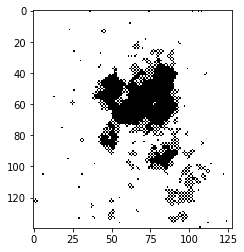

In [42]:
plt.imshow(hidden_image, cmap='gray')
print(hidden_image)
print (percent_pixel_flipped(hidden_image, img_arr))